# CASA0006 Data Science for Spatial Systems - Assessment

# Assessing and Evaluating the Various Factors Affecting the Proportion of Healthy Residents in London at the Ward Level in 2014

# 1 Introduction



## 1.1 Introduction and Literature review

Public health has consistently been a favored research area. As socioeconomic development has progressed, more studies have increasingly focused on residents' health levels. Interestingly, these studies do not uniformly praise the advancements brought about by societal development; they present a variety of viewpoints. Wang et al. (2013) investigated China's healthcare system and noted significant improvements in the health levels of residents over the past 20 years, alongside reforms and enhancements to the medical system. Other research highlights the drawbacks of development. Sun et al. examined the urbanization of Chinese provinces from 2005 to 2020 (2023), finding significant advances in urbanization levels but noting that environmental pollution exacerbated by urbanization has also worsened residents' health.

Residents' health, as a complex variable, has attracted many researchers. It often involves multiple aspects, such as social environment, socioeconomic, and personal factors. Molarius et al. (2007) conducted a study in central Sweden, exploring the link between socioeconomic conditions, lifestyle, and residents' health. They discovered a significant association between job satisfaction and health. Viner and his colleagues focused on adolescents (2012), investigating the impact of social factors at various levels—individual, family, community, and national—on adolescent health. They suggested structural reforms as interventions and called for employment and educational opportunities improvements. Xu et al. (2022) utilized machine learning methods, employing Random Forest and XGBoost algorithms to study the health levels of residents within Chinese provincial panels. They found that per capita GDP, population density, and the number of industrial enterprises significantly impacted residents' health.

Inspired by the literature above, this assessment aims to employ various machine learning methods and to conduct a case study focusing on London. It explores the relationship between socioeconomic factors, environmental conditions, personal habits, and residents' health, as well as identifying which factors most significantly impact residents' health and predicting health outcomes. The methods include multiple linear regression (MLR), Least absolute shrinkage and selection operator (LASSO), and Random Forest (RF). An introduction to the methods, a comparison of results, and a discussion will also be presented.



## 1.2 Research question

This assessment aims to respond to the following research question: <span style="color:blue">How do various factors such as socioeconomic status, community environment, and personal habits affect the proportion of healthy residents in London at the ward level in 2014, and which factors exert the most significant influence?</span>

In this assessment, we will define and use the proportion of healthy residents as the variable representing the health level of the residents, which is our research of interest. The data on the proportion of healthy residents can easily be calculated from the London census dataset related to health (London Datastore, 2013). We also set the research timeline to 2014, a decade ago. Studying the past can create more opportunities for comparative research, enhancing the depth and breadth of the field. Additionally, older datasets provide comprehensive and accurate data, which can enhance the reliability of analyses.

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# for qqplot
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
# for adding some text in plot
from matplotlib.offsetbox import AnchoredText

# for train test split, for cross validation, and for measure
import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve
from sklearn.metrics import mean_squared_error as MSE
# for data standard scaler
from sklearn.preprocessing import StandardScaler

# for Multiple linear regression
from statsmodels.formula.api import ols
from statsmodels.iolib.summary2 import summary_col

# for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

# for LASSO
from sklearn.linear_model import Lasso
# for searching the best alpha (lambda)
from sklearn.linear_model import LassoCV
# for plot the lasso path
from sklearn.linear_model import lasso_path

# for Random forest
from sklearn.ensemble import RandomForestRegressor
# for feature importance
import rfpimp

# 2 Presentation of data



## 2.1 Data set and Data Processing

The World Health Organization (2017) highlighted that determinants of health include the socioeconomic environment, physical environment, and individual behaviors. Durch's book (1997) also noted that the principal forces impacting health are heredity, lifestyles, environment, and health care services. A document referenced in the introduction by Xu et al. (2022) selects feature variables from three perspectives: economic, environmental, and social.

Following the review and understanding of the aforementioned information, we have decided to proceed with data collection in the following manner and to create a dataset. The dataset will include observations from 625 wards in London. We have opted to select ten ward features that we consider to be the most critical explanatory variables based on these aspects: socioeconomic status, social environment, natural environment, personal lifestyle habits, and health care. These features include population density, employment rate, median household income, the percentage of residents with no qualifications, the percentage of residents providing no unpaid care, the percentage of obese children in year 6, rates of ambulance call-outs for alcohol-related illness, crime rate, the percentage of open space area, and PM2.5 concentration as an indicator of pollution. Our response variable is the proportion of healthy residents, which is defined as:
$$
\text{the proportion of healthy residents}=\left(\frac{\text{Very good health residents} + \text{Good health residents} + \text{Fair health residents}}{\text{All residents}} \times 100\right) \%.
$$

Below is a summary table of the variables, showing the level of measurement. The variable names have been abbreviated for use in subsequent experiments. The variable with indexes X5 and Y can be calculated from the health dataset in the 2011 London Census (London Datastore, 2013). The variable with index X10 comes from the dataset "Estimation of Health Impacts of Particulate Pollution in London" (London Datastore, 2008). The other variables are selected from the dataset "Ward Profiles and Atlas" (London Datastore, 2014). The latter two datasets are releases by the Greater London Authority.

In [2]:
# showing the summary table of the variables

# variable names
var_name = ['population_density', 'employment_rate', 'median_household_income', 'no_qualifications',
            'no_unpaid_care', 'obese', 'alcohol', 'crime_rate',
            'open_space', 'pollution',
            'healthy_proportion']

# variable index
var_x_index = []
for i in range(1, 11):
    var_x_index = var_x_index + [f'X{i}']
var_index = var_x_index + ['Y']

# variable types
var_type = ['Explanatory variable']*10 + ['Response variable']

# variable level of measurement
var_measure = ['Ratio']*11

# creating report data frame
var_table = pd.DataFrame({'Variable_name': var_name,
                          'Variable_index': var_index,
                          'Variable_type': var_type,
                          'Level_of_measurement': var_measure})
var_table

,Variable_name,Variable_index,Variable_type,Level_of_measurement
0,population_density,X1,Explanatory variable,Ratio
1,employment_rate,X2,Explanatory variable,Ratio
2,median_household_income,X3,Explanatory variable,Ratio
3,no_qualifications,X4,Explanatory variable,Ratio
4,no_unpaid_care,X5,Explanatory variable,Ratio
5,obese,X6,Explanatory variable,Ratio
6,alcohol,X7,Explanatory variable,Ratio
7,crime_rate,X8,Explanatory variable,Ratio
8,open_space,X9,Explanatory variable,Ratio
9,pollution,X10,Explanatory variable,Ratio


Below, we will demonstrate the complete process of creating the required dataset, which includes importing the selected data tables, organizing them, calculating variables, and cleaning the data. The pollution dataset is the simplest and requires minimal manipulation. The Ward Profiles dataset and the London Census Health dataset are more complex. I've written a function called select_ward_row(), which uses the new ward codes to select the data we need. I also wrote check_sum_NA() to check how many NA values each column contains and discovered that the 'obese' variable contains 12 NA values. I deleted these rows directly because the number of NAs is relatively small. At this stage, I have not yet removed outliers, because our dataset does not contain type 1 outliers. We must observe the data patterns to determine whether these outliers are type 2 or 3. Type 2 outliers, which do not follow the pattern, need to be removed. Type 3 outliers are essential to the overall pattern and must be retained. I have postponed this step.

In [3]:
# read the dataset London census 2011 - Health
health_url = "https://github.com/ShengAric92/CASA0006_assessment/raw/main/HEALTH.xlsx"
health_df = pd.read_excel(health_url, sheet_name = '2011 Data', skiprows=1)

In [4]:
# read the dataset Ward Profiles and Atlas
profile_url = "https://github.com/ShengAric92/CASA0006_assessment/raw/main/ward-profiles-excel-version.xls"
profile_df = pd.read_excel(profile_url, sheet_name = 'Data')

In [5]:
# read the dataset Estimation of Health Impacts of Particulate Pollution in London
pollution_url = "https://github.com/ShengAric92/CASA0006_assessment/raw/main/particulate-air-pollution-mortality.csv"
# encoding with latin1, skiprows=[1] only the second row is skipped
pollution_df = pd.read_csv(pollution_url, low_memory=False, encoding='latin1', skiprows=[1])

In [6]:
# define a function for selecting necessary data information
def select_ward_row(df, code_col_name):

    # Apart from the City of London, the first ward is Abbey,
    # with the new code E05000026 and the old code 00ABFX.
    # In the old ward system, Westminster - West End was the last ward,
    # We use its new code E05000649 and old code 00BKGW for this purpose.
    df_COL = df.index[df[code_col_name] == 'E09000001'].tolist()[0]
    df_abbey = df.index[df[code_col_name] == 'E05000026'].tolist()[0]
    df_westend = df.index[df[code_col_name] == 'E05000649'].tolist()[0]
    # Place the indices for the City of London and all rows from Abbey to West End into a single list.
    row_index = [df_COL] + list(range(df_abbey, df_westend+1))
    df = df.loc[row_index]
    # reset row index
    df = df.reset_index(drop=True)
    return df

In [7]:
# select necessary data information by applying our function
profile_df = select_ward_row(profile_df, 'New code')
health_df = select_ward_row(health_df, 'ZONEID')

In [8]:
# according to keywords，in profile data, select our variables
profile_keywords = ['population density', 'year 6 who are obese', 'alcohol',
                   'employment rate', 'household income', 'no qualifications',
                   'crime rate', 'open space']
profile_filter = '|'.join(profile_keywords)
profile_df = profile_df.filter(regex=f'(?i){profile_filter}').copy()
# change the columns name
profile_df.columns = ['population_density', 'obese', 'alcohol', 'employment_rate',
                      'median_household_income', 'no_qualifications',
                      'crime_rate', 'open_space']

In [9]:
# calculate the percentage of resident provides no unpaid health care
health_care = health_df.filter(regex='care').copy()
health_care['no_unpaid_care'] = (health_care.iloc[:,0]/health_care.sum(axis = 1)) * 100

# for our response variable, calculate the proportion of healthy residents: healthy_resident
health_health = health_df.filter(regex='health').copy()
health_health['healthy_proportion'] = ((health_health.iloc[:,0] +
                                      health_health.iloc[:,1] + 
                                      health_health.iloc[:,2])/health_health.sum(axis = 1)) * 100

In [10]:
# create our desired dataframe
ward_df = pd.DataFrame()
# ward code and ward name
ward_df['ward_code'] = health_df['ZONEID']
ward_df['ward_name'] = health_df['ZONELABEL']
# insert variables in profile_df
ward_df = pd.concat([ward_df, profile_df], axis=1)
# insert pollution variable
ward_df['pollution'] = (pollution_df.filter(regex='(?i)PM2.5 concentration').copy()).iloc[:,0]
# insert no_unpaid_care and healthy_proportion
ward_df['no_unpaid_care'] = health_care['no_unpaid_care']
ward_df['healthy_proportion'] = health_health['healthy_proportion']

# change column name order
ward_colname_order = ['ward_code', 'ward_name',
                'population_density', 'employment_rate', 'median_household_income', 'no_qualifications',
                'no_unpaid_care', 'obese', 'alcohol', 'crime_rate',
                'open_space', 'pollution',
                'healthy_proportion']
ward_df = ward_df[ward_colname_order]

In [11]:
# show our desired data frame
ward_df

,ward_code,ward_name,population_density,employment_rate,median_household_income,no_qualifications,no_unpaid_care,obese,alcohol,crime_rate,open_space,pollution,healthy_proportion
0,E09000001,City of London,2538.062371,79.632867,63620,6.7,92.189831,23.214286,19.343303,656.38114,18.629014,17.59,96.664407
1,E05000026,Abbey,10500,60.348077,33920,16.4,93.242609,24.716553,1.342991,138.13923,21.908601,15.39,95.674957
2,E05000027,Alibon,7428.6,63.107388,32470,31.2,90.987000,25.995316,0.864631,73.589768,20.621849,14.86,93.288397
3,E05000028,Becontree,9269.2,61.192441,33000,28,91.390212,29.258517,0.612745,79.904148,1.885448,14.94,93.035946
4,E05000029,Chadwell Heath,2985.3,63.639393,33920,29.1,90.400160,24.585635,0.780572,76.125245,55.974507,14.80,93.194292
...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,E05000645,Tachbrook,20750,75.19084,47340,12.5,92.645256,32,0.693888,57.701478,32.385809,16.47,94.349105
621,E05000646,Vincent Square,14714.3,69.016213,46550,11.7,92.430917,24.848485,1.481139,82.429291,26.353986,16.70,94.353224
622,E05000647,Warwick,15916.7,73.767798,50250,9.4,92.677981,25.225225,3.563807,138.052365,4.022371,16.77,94.780660
623,E05000648,Westbourne,18500,58.998631,32390,22.4,92.225096,26.558891,0.768654,75.471698,19.239428,16.69,91.229720


In [12]:
# Check if the data type of the variable is correct;
# it should be a float. If not, use astype to convert it.
for i in ward_colname_order[2:]:
    if ward_df[i].dtype != np.dtype('float64'):
        ward_df[i] = ward_df[i].astype(float)

In [13]:
# define a function to check NA
def check_sum_NA(df):
    
    sum_val = [] # blank for appending
    col_name = df.columns.tolist() # tolist columns name
    for i in col_name:
        # sum na calcualtion
        na_val = df[i].isna().sum()
        sum_val.append(na_val)
        
    # createing a dataframe to report the na
    na_report = pd.DataFrame({'variable_name': col_name, 'NA_sum': sum_val})
    
    return na_report

In [14]:
check_sum_NA(ward_df)

,variable_name,NA_sum
0,ward_code,0
1,ward_name,0
2,population_density,0
3,employment_rate,0
4,median_household_income,0
5,no_qualifications,0
6,no_unpaid_care,0
7,obese,12
8,alcohol,0
9,crime_rate,0


In [15]:
# delete row with NA then check again
ward_df = ward_df.dropna(subset=['obese'])
check_sum_NA(ward_df)

,variable_name,NA_sum
0,ward_code,0
1,ward_name,0
2,population_density,0
3,employment_rate,0
4,median_household_income,0
5,no_qualifications,0
6,no_unpaid_care,0
7,obese,0
8,alcohol,0
9,crime_rate,0


In [16]:
# show recent ward_df
# after delete NA, we have 613 rows now
ward_df

,ward_code,ward_name,population_density,employment_rate,median_household_income,no_qualifications,no_unpaid_care,obese,alcohol,crime_rate,open_space,pollution,healthy_proportion
0,E09000001,City of London,2538.062371,79.632867,63620.0,6.7,92.189831,23.214286,19.343303,656.381140,18.629014,17.59,96.664407
1,E05000026,Abbey,10500.000000,60.348077,33920.0,16.4,93.242609,24.716553,1.342991,138.139230,21.908601,15.39,95.674957
2,E05000027,Alibon,7428.600000,63.107388,32470.0,31.2,90.987000,25.995316,0.864631,73.589768,20.621849,14.86,93.288397
3,E05000028,Becontree,9269.200000,61.192441,33000.0,28.0,91.390212,29.258517,0.612745,79.904148,1.885448,14.94,93.035946
4,E05000029,Chadwell Heath,2985.300000,63.639393,33920.0,29.1,90.400160,24.585635,0.780572,76.125245,55.974507,14.80,93.194292
...,...,...,...,...,...,...,...,...,...,...,...,...,...
620,E05000645,Tachbrook,20750.000000,75.190840,47340.0,12.5,92.645256,32.000000,0.693888,57.701478,32.385809,16.47,94.349105
621,E05000646,Vincent Square,14714.300000,69.016213,46550.0,11.7,92.430917,24.848485,1.481139,82.429291,26.353986,16.70,94.353224
622,E05000647,Warwick,15916.700000,73.767798,50250.0,9.4,92.677981,25.225225,3.563807,138.052365,4.022371,16.77,94.780660
623,E05000648,Westbourne,18500.000000,58.998631,32390.0,22.4,92.225096,26.558891,0.768654,75.471698,19.239428,16.69,91.229720


## 2.2 Data distribution

Below, we illustrate the distribution of the data by drawing boxplots and QQ plots. The boxplots highlight the need to pay particular attention to the variables 'alcohol' and 'crime rate' as they contain many outliers. We must carefully determine whether they follow a pattern. Meanwhile, the QQ plots allow us to assess whether certain variables follow a normal distribution: employment rate, median household income, no qualifications, no unpaid care, obese, and health proportion.

In [17]:
# drop the ward name and code for check data distribution
ward_data = ward_df.drop(['ward_name', 'ward_code'], axis=1)

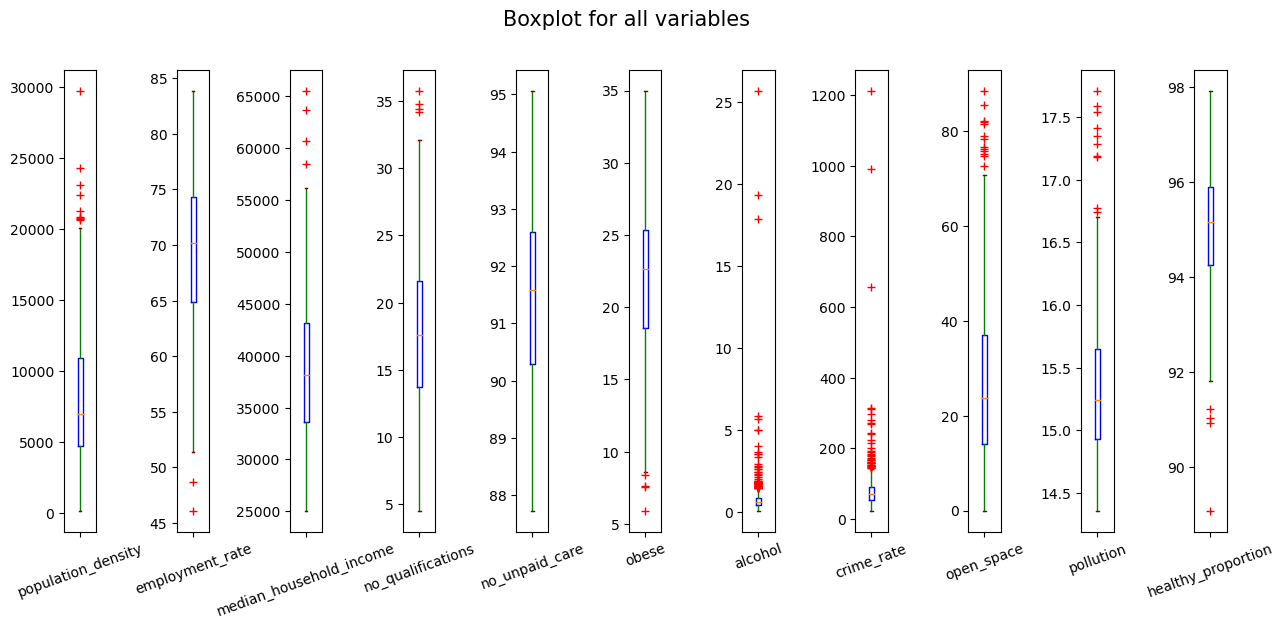

In [18]:
# plot the boxplot for all variables
fig, axes = plt.subplots(1, 11, figsize=(15, 6))
ward_data.plot(kind='box', ax=axes, subplots=True,
            color=dict(boxes='blue', medians='DarkOrange', whiskers='green', caps='maroon'),
            sym='r+', rot = 20)

fig.subplots_adjust(wspace=2.5)
fig.suptitle('Boxplot for all variables', fontsize=15)
plt.show()

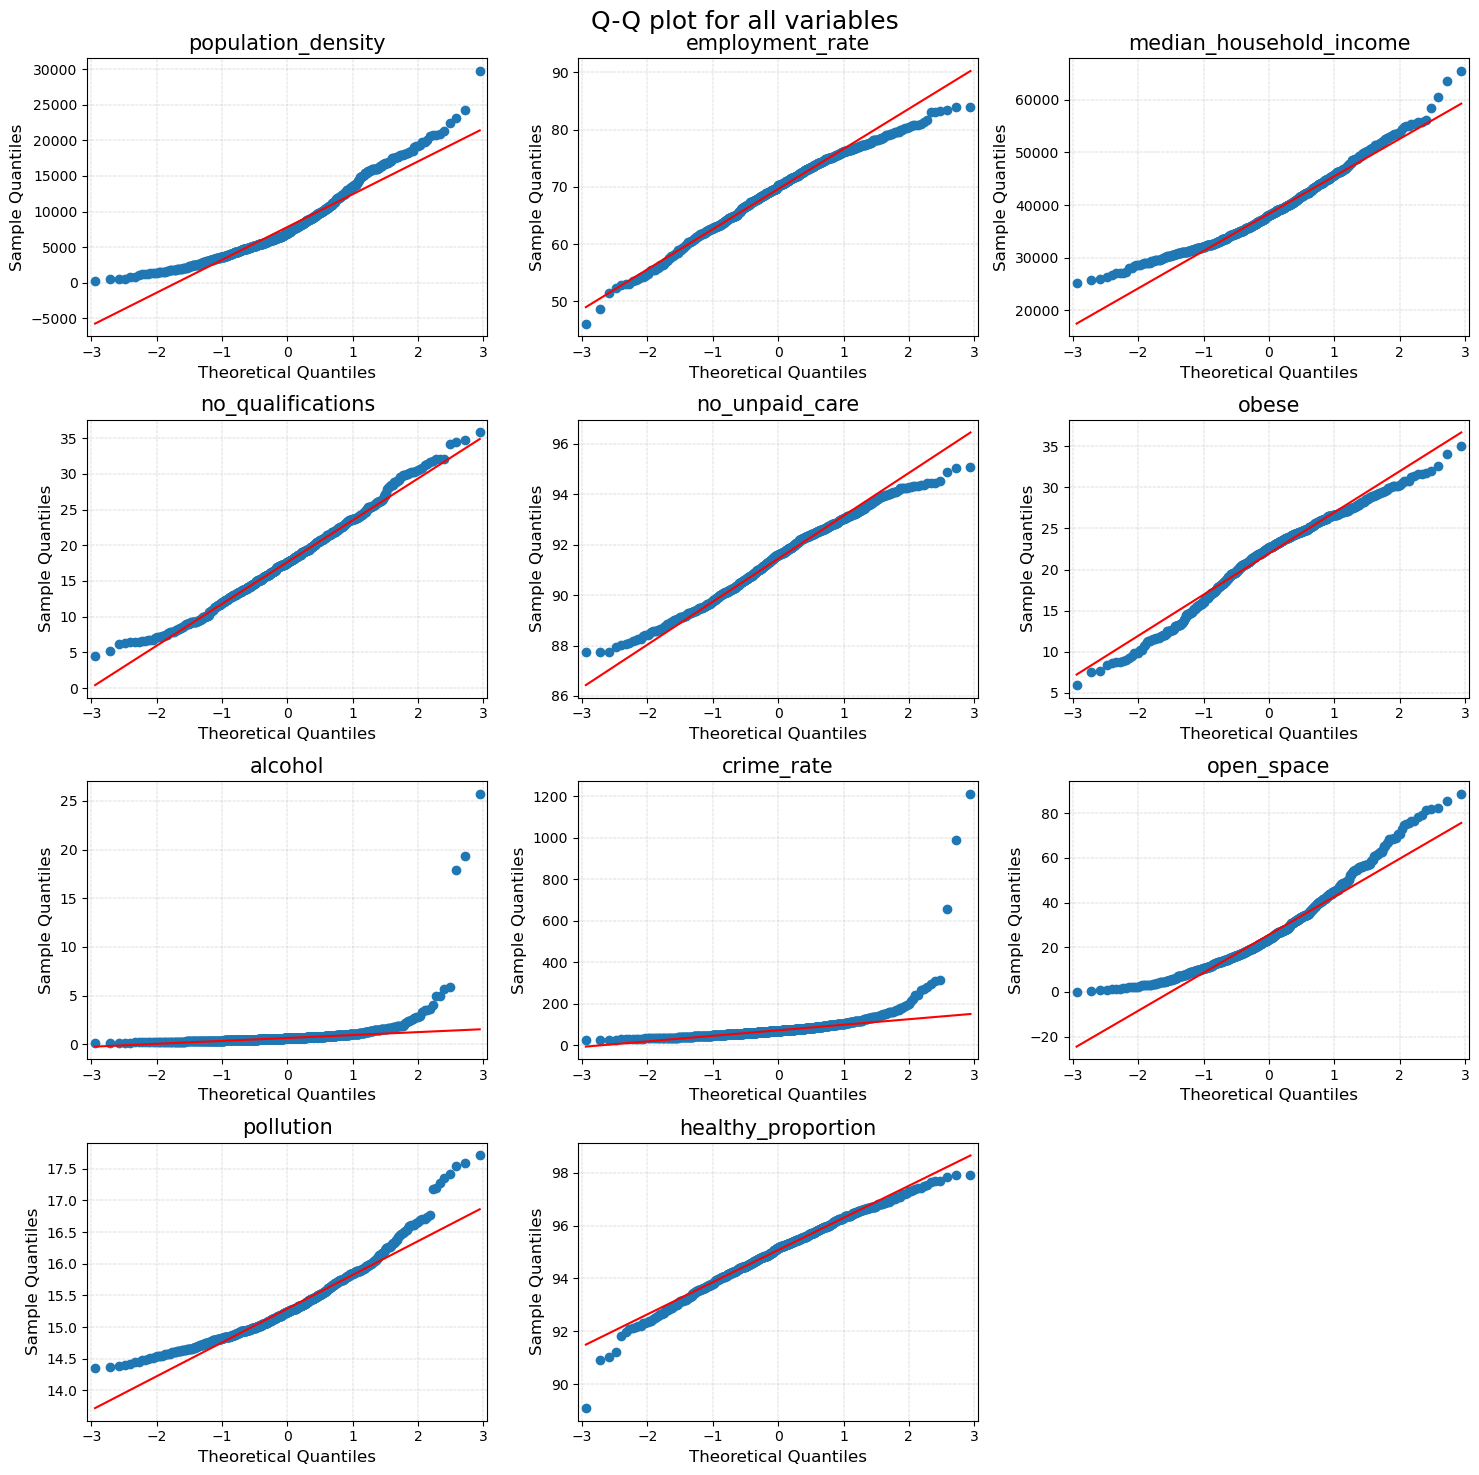

In [19]:
# plot the qqplot for all variables
fig, axes = plt.subplots(4, 3, figsize=(15, 15), sharey=False)

for i, (col, ax) in enumerate(zip(ward_data.columns, axes.flatten())):
    qqplot(ward_data[col], line='q', ax=ax)
    ax.set_title(f'{col}', fontsize=15)
    # set x and y label
    ax.set_xlabel('Theoretical Quantiles', fontsize=12)
    ax.set_ylabel('Sample Quantiles', fontsize=12)
    # add grid
    ax.grid(linestyle='-.', linewidth=0.3)
    
fig.suptitle('Q-Q plot for all variables', fontsize=18)
plt.tight_layout()
# do not show the last axis subplot since its empty
axes[-1, -1].axis('off')

plt.show()

# 3 Methodology

We employ Multiple Linear Regression, LASSO, and Random Forest to address our research question. We aim to determine which variables have a more significant impact on residents' health and make predictions regarding health outcomes.

We split our dataset into training and testing sets using a 75:25 ratio. Additionally, we notice significant differences in the scale of our variables. Since we opt for LASSO, which penalizes regression coefficients, it is advisable to keep all features on the same scale. As we seek to compare models, the best practice is to standardize the data and apply it to all three models. We utilize Z-score standardization, which can be implemented in Python using StandardScaler from the sklearn.preprocessing module.

Another advantage of this approach is that it allows us to directly compare the standardized regression coefficients in MLR to determine which variables have a more significant impact.



## 3.1 Core method 1 Multiple Linear Regression

Based on our data, the formula for the multiple regression model is as follows:

$$
Y=\beta_0+\beta_1 X_1+\beta_2 X_2+\ldots+\beta_{10} X_{10}+\epsilon,
$$

where $\epsilon$ represents the error term. We can predict the outcome as:

$$
\hat{Y}=\beta_0+\beta_1 X_1+\beta_2 X_2+\ldots+\beta_{10} X_{10}.
$$

Additionally, it needs to avoid multicollinearity and must meet necessary conditions, which include homoscedasticity, errors in normal distribution, independent errors, and the existence of a linear relationship.


## 3.2 Core method 2 LASSO Regression

LASSO regression imposes an L1 penalty on the regression coefficients. This L1 penalty can shrink coefficients to zero, thereby facilitating variable selection and simplifying the model. LASSO is particularly effective in addressing issues of multicollinearity.
In LASSO regression, the hyperparameter is $\lambda$, which controls the strength of the L1 penalty. When $\lambda$ is zero, it equates to standard MLR. As $\lambda$ increases, more coefficients are compressed to zero. We can utilize LassoCV to find the optimal value of $\lambda$.



## 3.3 Core method 3 Random Forest Regression

Random Forest Regression is a type of ensemble learning algorithm. It employs bootstrap sampling from the original data and constructs decision trees for the samples. It can build numerous trees to form a forest, and the final prediction is made by averaging the results from these multiple decision trees. Hyperparameters in RF include max_depth, min_samples_split, n_estimators, max_features, etc. We can use GridSearchCV to find the optimal combination of hyperparameters.

# 4 Results and Discussion



## (4.0 Before Multiple Linear Regression)

Before performing Multiple Linear Regression (MLR), I plotted scatter plots of the X variables against the Y variable and checked the Pearson correlation coefficient. I found that the outliers for the variables alcohol and crime rate indeed do not follow the pattern thus they need to be removed. To avoid removing too much data, I used the 1% and 99% rule instead of the IQR rule.

In [20]:
# correlation matrix
cormatrix = ward_data.corr(method='pearson')
# record the correlation coefficient values
corcoef_list = cormatrix['healthy_proportion'].tolist()

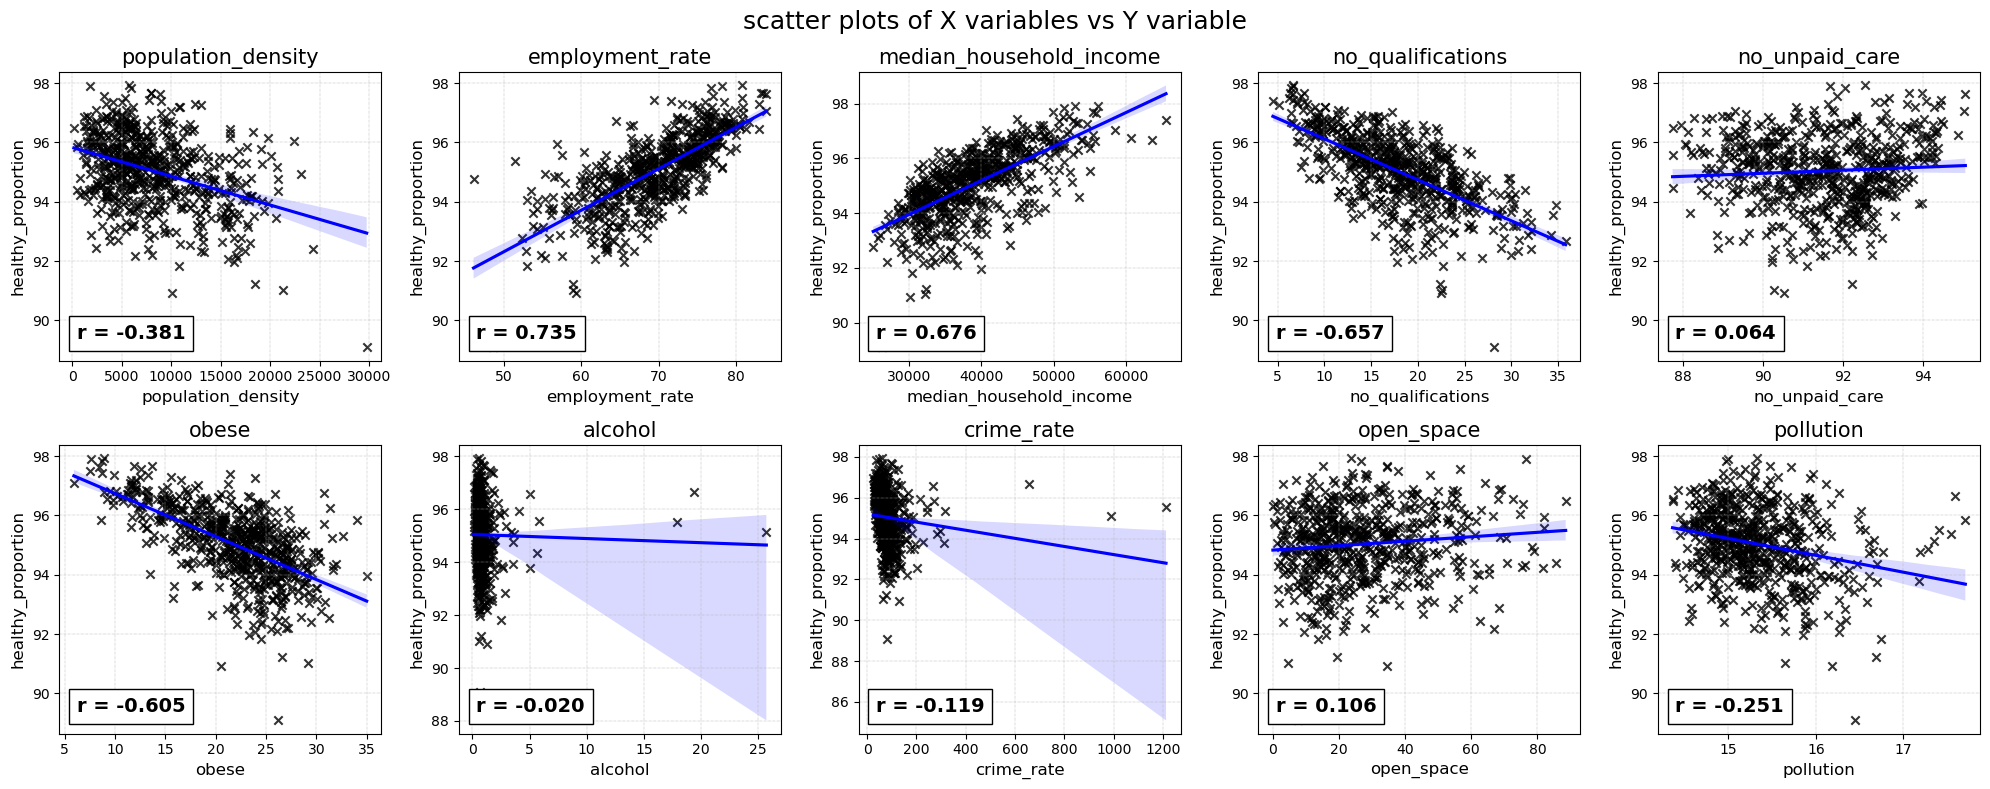

In [21]:
# plot the scatter plots of explanatory variables vs response variable
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=False)
for i, (col, ax) in enumerate(zip(ward_data.columns, axes.flatten())):
    sns.regplot(x = f'{col}', y = 'healthy_proportion',
                data = ward_data, color = 'black', marker='x', ax = ax,
                line_kws = {"color": "blue"})
    ax.set_title(f'{col}', fontsize=15)
    ax.set_xlabel(f'{col}', fontsize=12)
    ax.set_ylabel('healthy_proportion', fontsize=12)
    ax.grid(linestyle='-.', linewidth=0.3)
    # adding text of pearson correlation coefficient
    ax.add_artist(AnchoredText(f"r = {corcoef_list[i]:.3f}", loc=3,
                               prop=dict(size='14', color='k', weight='bold')))

fig.suptitle('scatter plots of X variables vs Y variable', fontsize = 18)
plt.tight_layout()
plt.show()

In [22]:
# using 1% 99% rule to clean outliers
def clean_outlier(df, df_col):
    
    # calculate the 1st quantile and 99th quantile for df_col
    q1 = df[df_col].quantile(0.01)
    q99 = df[df_col].quantile(0.99)
    
    # 1-99 rule
    df = df.drop(df[(df[df_col] < q1) | (df[df_col] > q99)].index)
        
    return df

In [23]:
# clean outliers in alcohol and crime rate variable
ward_data = clean_outlier(ward_data, 'alcohol')
ward_data = clean_outlier(ward_data, 'crime_rate')
# show the data set, not we have 587 observations
ward_data

,population_density,employment_rate,median_household_income,no_qualifications,no_unpaid_care,obese,alcohol,crime_rate,open_space,pollution,healthy_proportion
1,10500.0,60.348077,33920.0,16.4,93.242609,24.716553,1.342991,138.139230,21.908601,15.39,95.674957
2,7428.6,63.107388,32470.0,31.2,90.987000,25.995316,0.864631,73.589768,20.621849,14.86,93.288397
3,9269.2,61.192441,33000.0,28.0,91.390212,29.258517,0.612745,79.904148,1.885448,14.94,93.035946
4,2985.3,63.639393,33920.0,29.1,90.400160,24.585635,0.780572,76.125245,55.974507,14.80,93.194292
5,3028.6,68.221661,37400.0,29.9,90.376927,21.562500,0.705946,66.666667,50.434179,14.66,94.089092
...,...,...,...,...,...,...,...,...,...,...,...
618,5326.1,62.437901,46510.0,13.0,92.549930,20.833333,1.237825,66.553453,62.225603,16.06,93.991879
620,20750.0,75.190840,47340.0,12.5,92.645256,32.000000,0.693888,57.701478,32.385809,16.47,94.349105
621,14714.3,69.016213,46550.0,11.7,92.430917,24.848485,1.481139,82.429291,26.353986,16.70,94.353224
622,15916.7,73.767798,50250.0,9.4,92.677981,25.225225,3.563807,138.052365,4.022371,16.77,94.780660


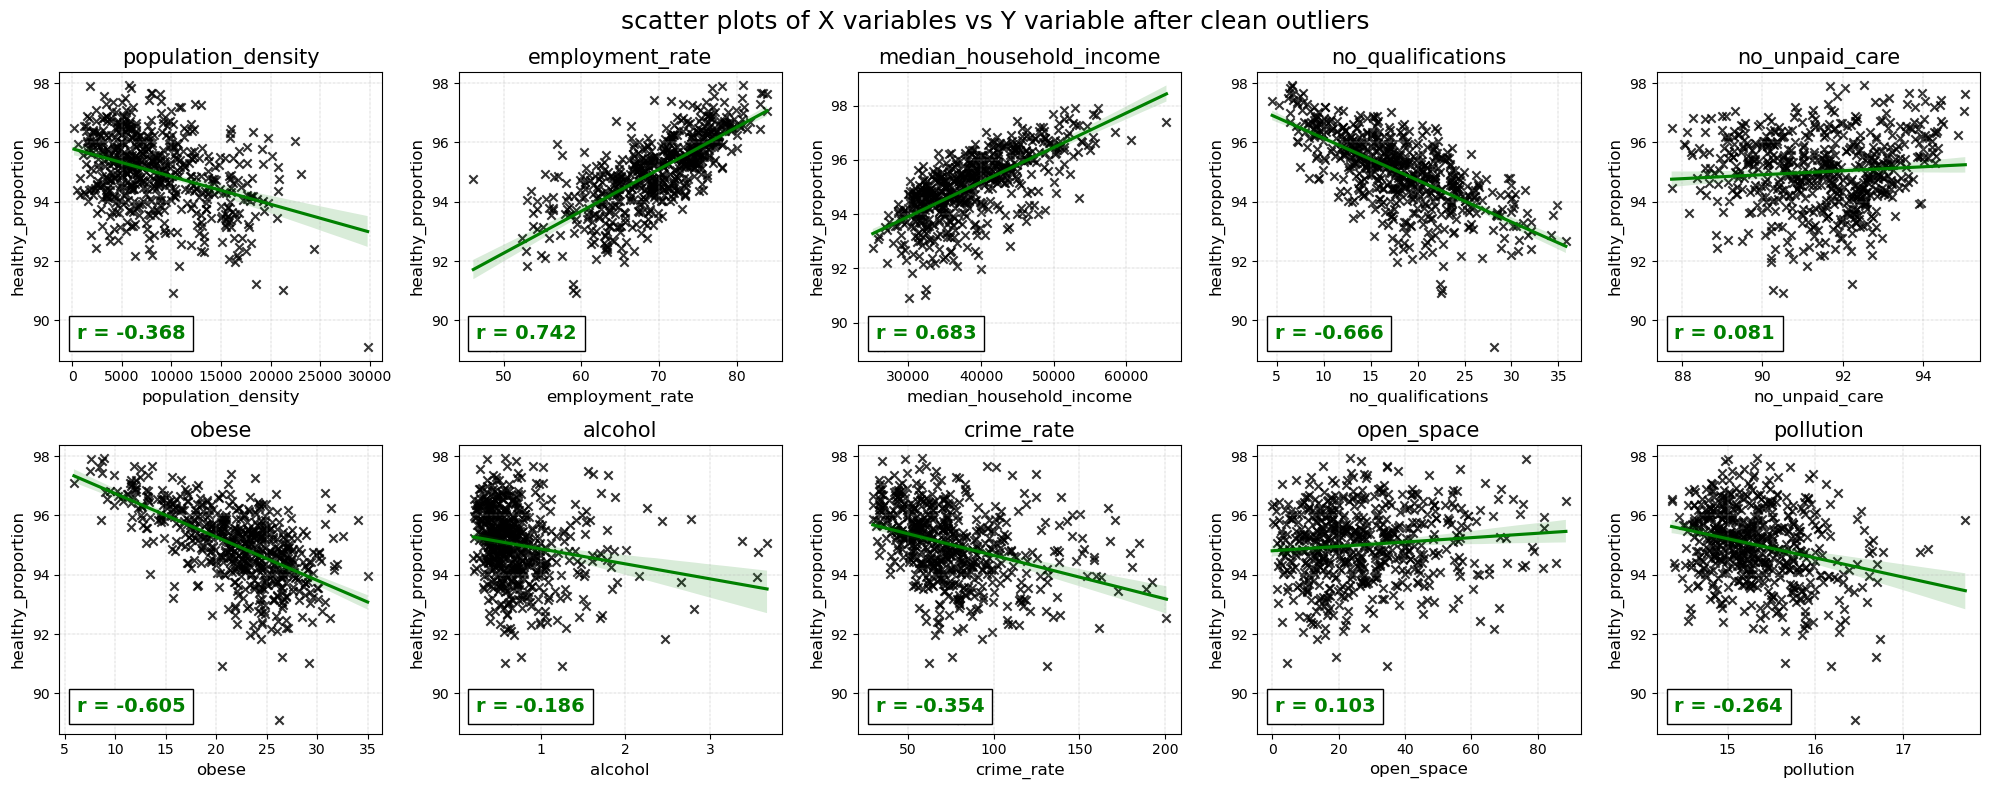

In [24]:
# plot again after clean the outliers
# correlation matrix
cormatrix = ward_data.corr(method='pearson')
# record the correlation coefficient values
corcoef_list = cormatrix['healthy_proportion'].tolist()
# plot the scatter plots of explanatory variables vs response variable
fig, axes = plt.subplots(2, 5, figsize=(20, 8), sharey=False)
for i, (col, ax) in enumerate(zip(ward_data.columns, axes.flatten())):
    sns.regplot(x = f'{col}', y = 'healthy_proportion',
                data = ward_data, color = 'black', marker='x', ax = ax,
                line_kws = {"color": "green"})
    ax.set_title(f'{col}', fontsize=15)
    ax.set_xlabel(f'{col}', fontsize=12)
    ax.set_ylabel('healthy_proportion', fontsize=12)
    ax.grid(linestyle='-.', linewidth=0.3)
    # adding text of pearson correlation coefficient
    ax.add_artist(AnchoredText(f"r = {corcoef_list[i]:.3f}", loc=3,
                               prop=dict(size='14', color='green', weight='bold')))

fig.suptitle('scatter plots of X variables vs Y variable after clean outliers', fontsize = 18)
plt.tight_layout()
plt.show()

## 4.1 Multiple Linear Regression

Here is the execution of the Multiple Linear Regression (MLR). After standardizing the data, we used correlation analysis to examine the correlation coefficients of the explanatory variables and found potential multicollinearity between 'no qualification' and 'median household income'. Using the code from Practical 07, we further calculated the Variance Inflation Factor (VIF) and found that no variables needed to be removed. After conducting MLR, the Durbin-Watson test and Jarque-Bera test values were normal, meeting the assumptions of linear regression.

Our R² is 0.793, which is quite high and optimistic, indicating that the model explains 79.3% of the variance in the data. By directly comparing standardized coefficients, we found that the most significant variable is 'no qualifications' (-0.616), followed by 'population density' (-0.553), and several other variables such as 'pollution,' 'no unpaid care,' and 'employment rate' are also very important. The least significant variable is 'alcohol', followed by 'obese'.

In [25]:
# train test split
random_state_split = 77
train_x, test_x, train_y, test_y = train_test_split(ward_data.drop('healthy_proportion', axis = 1),
                                                    ward_data.healthy_proportion,
                                                    random_state=random_state_split)

In [26]:
# data standardization
scale = StandardScaler()
train_x_scale = scale.fit_transform(train_x)
train_x_scale_df = pd.DataFrame(train_x_scale, columns=train_x.columns, index=train_x.index)

test_x_scale = scale.transform(test_x)
test_x_scale_df = pd.DataFrame(test_x_scale, columns=test_x.columns, index=test_x.index)

In [27]:
# train and test set for apply ols
train_set = train_x_scale_df
train_set['healthy_proportion'] = train_y

test_set = test_x_scale_df
test_set['healthy_proportion'] = test_y

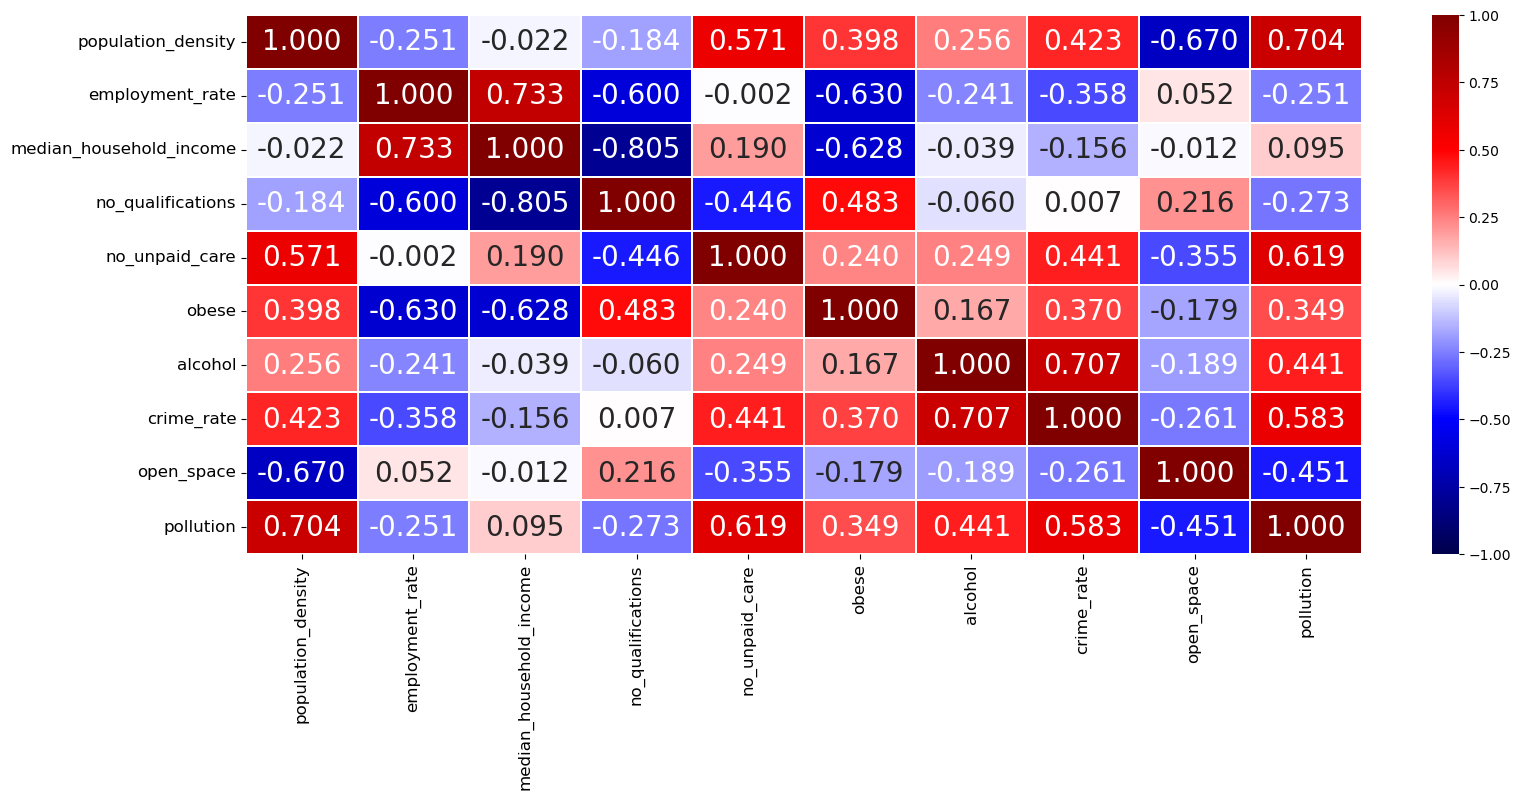

In [28]:
# correlation matrix for training x set
cormatrix_train_x = train_x.corr(method='pearson')

# plot the correlation matrix plot for training x set
fig, axes = plt.subplots(figsize = (18,7))
sns.heatmap(cormatrix_train_x, annot = True, fmt='.3f',
            linewidths = 0.1, annot_kws = {'size': 20},
            cmap ='seismic',
            vmin=-1, vmax=1, ax=axes)
axes.tick_params(labelsize = 12)
plt.show()

In [29]:
# using the practical 07 code for apply VIF for variable selection
# this code origin from https://stackoverflow.com/a/51329496/4667568
def drop_column_using_vif_(df, list_var_not_to_remove=None, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param list_var_not_to_remove: the list of variables that should not be removed even though it has a high VIF. For example, dummy (or indicator) variables represent a categorical variable with three or more categories.
    :param thresh: the max VIF value before the feature is removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const as const should not be removed
        vif_df = vif_df.drop('const')
        
        # drop the variables that should not be removed
        if list_var_not_to_remove is not None:
            vif_df = vif_df.drop(list_var_not_to_remove)
            
        print('Max VIF:', vif_df.VIF.max())
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [30]:
# apply VIF in training x set
vif = drop_column_using_vif_(train_x, thresh=5)

Max VIF: 4.810624219728226


In [31]:
# doing MLR
# presenting the feature and make formula
x_var = '+'.join(ward_data.columns.difference(['healthy_proportion']))
reg_formula = f'healthy_proportion ~ {x_var}'

# fit the model and print the summary
model = ols(reg_formula, data=train_set).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     healthy_proportion   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.788
Method:                 Least Squares   F-statistic:                     164.5
Date:                Mon, 22 Apr 2024   Prob (F-statistic):          5.64e-140
Time:                        16:46:27   Log-Likelihood:                -379.56
No. Observations:                 440   AIC:                             781.1
Df Residuals:                     429   BIC:                             826.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [32]:
# adding predict Y for train and test set
train_set['healthy_proportion_predict'] = model.predict(train_set)
test_set['healthy_proportion_predict'] = model.predict(test_set)

In [33]:
# MLR R2 for training set
train_R2_MLR = model.rsquared

# calculate MLR R2 for testing set
SSRES = sum((test_set['healthy_proportion'] - test_set['healthy_proportion_predict']) ** 2)
SSTOT = sum((test_set['healthy_proportion'] - np.mean(test_set['healthy_proportion'])) ** 2)
test_R2_MLR = 1 - SSRES / SSTOT

In [34]:
# calculate MLR RMSE for training and testing set
train_RMSE_MLR = np.sqrt(MSE(train_set['healthy_proportion'],
                             train_set['healthy_proportion_predict']))
test_RMSE_MLR = np.sqrt(MSE(test_set['healthy_proportion'],
                            test_set['healthy_proportion_predict']))

In [35]:
# print these values
print("train R2 MLR:", train_R2_MLR)
print("test R2 MLR:", test_R2_MLR)

print("train RMSE MLR:", train_RMSE_MLR)
print("test RMSE MLR:", test_RMSE_MLR)

train R2 MLR: 0.7931990281584812
test R2 MLR: 0.7268343065137554
train RMSE MLR: 0.5733293130724186
test RMSE MLR: 0.6165729330992035


## 4.2 LASSO Regression

By using LassoCV, we identified the optimal $\lambda$ value as 0.014, which successfully compressed one variable to zero, namely alcohol, thereby simplifying the model. The plotting of the Lasso path made the changes in the coefficients of the variables clearly visible. Comparing the Lasso coefficients, we found that the most significant variables remain no qualification, population density, employment rate, and pollution. We also noted an increase in the regression coefficient for the employment rate, indicating its increased impact.

In [36]:
# reset for LASSO
# train test split
random_state_split = 77
train_x, test_x, train_y, test_y = train_test_split(ward_data.drop('healthy_proportion', axis = 1),
                                                    ward_data.healthy_proportion,
                                                    random_state=random_state_split)

# data standardization
scale = StandardScaler()
train_x_scale = scale.fit_transform(train_x)
train_x_scale_df = pd.DataFrame(train_x_scale, columns=train_x.columns, index=train_x.index)

test_x_scale = scale.transform(test_x)
test_x_scale_df = pd.DataFrame(test_x_scale, columns=test_x.columns, index=test_x.index)

In [37]:
# using LassoCV find the optimal lambda
lasso_cv = LassoCV(cv=5, random_state=100).fit(train_x_scale, train_y)

# using this optimal lambda
lasso =Lasso(alpha=lasso_cv.alpha_)
  
# fit the model
lasso.fit(train_x_scale, train_y)

Lasso(alpha=0.014269372745867669)

In [38]:
# check the coefficients
coefficients = pd.DataFrame({"Feature": train_x_scale_df.columns, "Coefficients": lasso.coef_})
print("Intercept:", lasso.intercept_)
print("Coefficients:", lasso.coef_)

# view this coefficient with feature name
print(coefficients.sort_values(by="Coefficients", ascending=False))

Intercept: 94.99271556592288
Coefficients: [-0.48574851  0.27357016  0.10067651 -0.60397389  0.25569098  0.02443471
 -0.         -0.14146798 -0.19783016 -0.27345053]
                   Feature  Coefficients
1          employment_rate      0.273570
4           no_unpaid_care      0.255691
2  median_household_income      0.100677
5                    obese      0.024435
6                  alcohol     -0.000000
7               crime_rate     -0.141468
8               open_space     -0.197830
9                pollution     -0.273451
0       population_density     -0.485749
3        no_qualifications     -0.603974


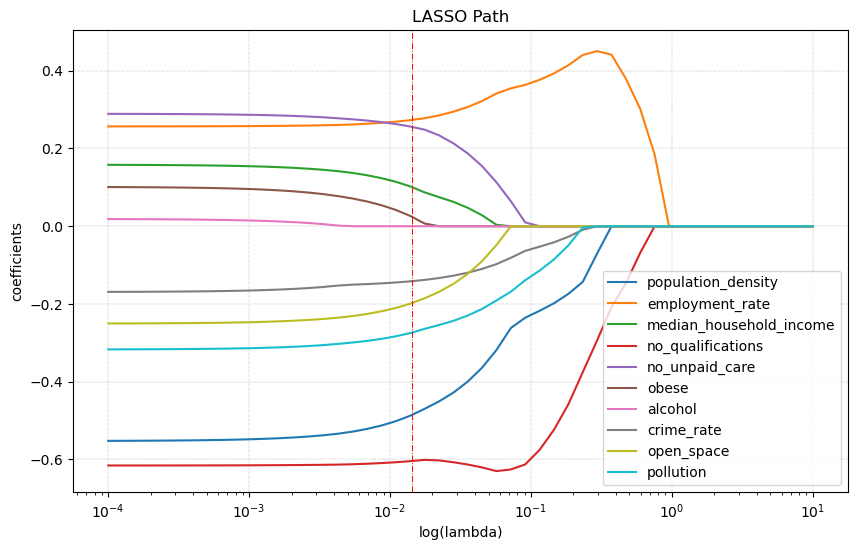

In [39]:
# plot the lasso path
alphas, coefs, _ = lasso_path(train_x_scale, train_y, alphas=np.logspace(-4, 1, 50))
plt.figure(figsize=(10, 6))
for i in range(coefs.shape[0]):
    plt.plot(alphas, coefs[i, :], label=train_x.columns[i])

plt.xscale('log')
# plot the line for best lambda
plt.axvline(x=lasso_cv.alpha_, color='r', linestyle='-.', linewidth=0.7)
plt.xlabel('log(lambda)')
plt.ylabel('coefficients')
plt.title('LASSO Path')
plt.grid(linestyle='-.', linewidth=0.3)
plt.legend()
plt.show()

In [40]:
# calculate R2
train_R2_LASSO = lasso.score(train_x_scale, train_y)
test_R2_LASSO = lasso.score(test_x_scale, test_y)

In [41]:
# calculate RMSE
train_y_pred = lasso.predict(train_x_scale)
test_y_pred = lasso.predict(test_x_scale)

train_RMSE_LASSO = np.sqrt(MSE(train_y, train_y_pred))
test_RMSE_LASSO = np.sqrt(MSE(test_y, test_y_pred))

In [42]:
# print these values
print("train R2 LASSO:", train_R2_LASSO)
print("test R2 LASSO:", test_R2_LASSO)

print("train RMSE LASSO:", train_RMSE_LASSO)
print("test RMSE LASSO:", test_RMSE_LASSO)

train R2 LASSO: 0.790062039715513
test R2 LASSO: 0.7460648321430058
train RMSE LASSO: 0.5776613965718098
test RMSE LASSO: 0.5944739155592285


## 4.3 Random Forest Regression

By using GridSearchCV, we found the most suitable set of hyperparameters, specifically a max_depth of 30 and a min_samples_split of 4. By calculating feature importance, we discovered that the top four variables remain the employment rate, no qualification, population density, and pollution. However, in the Random Forest Regression (RFR), the importance of the employment rate is particularly high, ranking first, while the weight of pollution has significantly decreased.

In [43]:
# reset for RF Regression
# train test split
random_state_split = 77
train_x, test_x, train_y, test_y = train_test_split(ward_data.drop('healthy_proportion', axis = 1),
                                                    ward_data.healthy_proportion,
                                                    random_state=random_state_split)

# data standardization
scale = StandardScaler()
train_x_scale = scale.fit_transform(train_x)
train_x_scale_df = pd.DataFrame(train_x_scale, columns=train_x.columns, index=train_x.index)

test_x_scale = scale.transform(test_x)
test_x_scale_df = pd.DataFrame(test_x_scale, columns=test_x.columns, index=test_x.index)

In [44]:
# hyperparameters setting: max_depth and min_samples_split
hyper = {'max_depth':[10,20,30,40,50],
         'min_samples_split':[2,4,6,8,10]}

RF = RandomForestRegressor(random_state=8500)

# 5-fold cross-validation
CLF = GridSearchCV(RF, hyper, cv = 5)

CLF.fit(train_x_scale_df, train_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=8500),
             param_grid={'max_depth': [10, 20, 30, 40, 50],
                         'min_samples_split': [2, 4, 6, 8, 10]})

In [45]:
RFR = RandomForestRegressor(max_depth=CLF.best_params_['max_depth'],
                                 min_samples_split=CLF.best_params_['min_samples_split'],
                                 random_state=8500)
RFR.fit(train_x_scale_df, train_y)

RandomForestRegressor(max_depth=30, min_samples_split=4, random_state=8500)

                         Importance
Feature                            
employment_rate            0.549269
no_qualifications          0.207554
population_density         0.094282
no_unpaid_care             0.067045
pollution                  0.024922
median_household_income    0.010807
open_space                 0.004207
crime_rate                 0.002186
alcohol                    0.000141
obese                     -0.001840


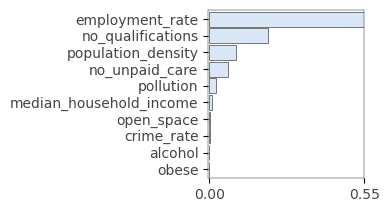

In [46]:
# view the feature importance
importance = rfpimp.importances(RFR, test_x_scale_df, test_y)
print(importance)
view_feature_importance = rfpimp.plot_importances(importance)
view_feature_importance.view()

In [47]:
# calculate R2
train_R2_RFR = RFR.score(X=train_x_scale_df, y=train_y)
test_R2_RFR = RFR.score(X=test_x_scale_df, y=test_y)

In [48]:
# calculate RMSE
train_RMSE_RFR = MSE(train_y, RFR.predict(train_x_scale_df), squared=False)
test_RMSE_RFR = MSE(test_y, RFR.predict(test_x_scale_df), squared=False)

In [49]:
# print these values
print("train R2 RFR:", train_R2_RFR)
print("test R2 RFR:", test_R2_RFR)

print("train RMSE RFR:", train_RMSE_RFR)
print("test RMSE RFR:", test_RMSE_RFR)

train R2 RFR: 0.9621324735166493
test R2 RFR: 0.7713848538245582
train RMSE RFR: 0.24533602706880195
test RMSE RFR: 0.5640581486978048


## 4.4 Models comparison and discussion

We observed that regardless of the model, the four variables with the highest weights have consistently been no qualification, population density, employment rate, and pollution. The two variables with the least weight are alcohol and obese.

Comparing LASSO with MLR, LASSO includes one less variable, but its test R2 is significantly higher than that of MLR. This indicates that in this case study, we successfully optimized the model using LASSO.

RFR, compared to other models, exhibits the highest test R2 and the lowest RMSE, indicating that it has the best interpretability and accuracy. However, its test R2 appears to be much lower compared to its own train R2, suggesting a potential overfitting problem.

In [50]:
# create compare table
model_name = ['MLR', 'LASSO', 'RFR']
train_R2_score = [train_R2_MLR, train_R2_LASSO, train_R2_RFR]
test_R2_score = [test_R2_MLR, test_R2_LASSO, test_R2_RFR]
train_RMSE_score = [train_RMSE_MLR, train_RMSE_LASSO, train_RMSE_RFR]
test_RMSE_score = [test_RMSE_MLR, test_RMSE_LASSO, test_RMSE_RFR]

model_comp_table = pd.DataFrame({'model_name': model_name,
                                 'train_R2_score': train_R2_score,
                                 'test_R2_score': test_R2_score,
                                 'train_RMSE_score': train_RMSE_score,
                                 'test_RMSE_score': test_RMSE_score})
model_comp_table

,model_name,train_R2_score,test_R2_score,train_RMSE_score,test_RMSE_score
0,MLR,0.793199,0.726834,0.573329,0.616573
1,LASSO,0.790062,0.746065,0.577661,0.594474
2,RFR,0.962132,0.771385,0.245336,0.564058


# 5 Conclusion

Through this case study, we have successfully answered our research question. All three models identified no qualification, population density, employment rate, and pollution as the variables most affecting residents' health. This outcome also resonates with the findings of previous literature reviews, including the studies by Xu and Viner. Although there is a relatively high negative linear correlation between the variable 'obese' and residents' health, correlation does not imply causation, and its impact is not significant.

While the predictive performance results indicate that Random Forest Regression (RFR) is the best, it may have an overfitting problem, which could be related to the training dataset itself. LASSO, on the other hand, performed excellently and successfully optimized the model. There is still room for improvement in this assessment. We could further consider spatial attributes. Considering spatial autocorrelation and attempting to apply Geographically Weighted Regression might enhance our analysis.

Words count: 1988

Github link: https://github.com/ShengAric92/CASA0006_assessment

# 6 Reference

Durch, J. S., Bailey, L. A., & Stoto, M. A. (Eds.). (1997). Improving health in the community: a role for performance monitoring.


London Datastore. (2013). '2011 Census', Census information scheme. Available at: https://data.london.gov.uk/census/2011-census/data/ [Accessed on 18 April 2024].


London Datastore. (2008). 'Estimation of Health Impacts of Particulate Pollution in London', Greater London Authority. Available at: https://data.london.gov.uk/dataset/estimation-health-impacts-particulate-pollution-london [Accessed on 18 April 2024].


London Datastore. (2014). 'Ward Profiles and Atlas', Greater London Authority. Available at: https://data.london.gov.uk/dataset/ward-profiles-and-atlas [Accessed on 18 April 2024].


Molarius, A., Berglund, K., Eriksson, C., Lambe, M., Nordström, E., Eriksson, H. G., & Feldman, I. (2007). Socioeconomic conditions, lifestyle factors, and self-rated health among men and women in Sweden. The European Journal of Public Health, 17(2), 125-133.


Sun, C., Wang, Y., & Zhu, Z. (2023). Urbanization and residents’ health: from the perspective of environmental pollution. Environmental Science and Pollution Research, 30(25), 67820-67838.


Viner, R. M., Ozer, E. M., Denny, S., Marmot, M., Resnick, M., Fatusi, A., & Currie, C. (2012). Adolescence and the social determinants of health. The lancet, 379(9826), 1641-1652.


Wang, C., Rao, K., Wu, S., & Liu, Q. (2013). Health care in China: improvement, challenges, and reform. Chest, 143(2), 524-531.


World Health Organization. (2017). 'Determinants of Health'. Available at: https://www.who.int/news-room/questions-and-answers/item/determinants-of-health [Accessed on 18 April 2024].


Xu, H., Pan, W., Xin, M., Pan, W., Hu, C., Wanqiang, D., & Huang, G. (2022). Study of the economic, environmental, and social factors affecting Chinese residents' health based on machine learning. Frontiers in Public Health, 10, 896635.